In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
image_folder = "./../data/training-a"
folder_info_csv = "./../data/training-a.csv"

In [3]:
df_info = pd.read_csv(folder_info_csv)
df_info.head()

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


# Visualizing image processing: original → cropped → normalized → binary

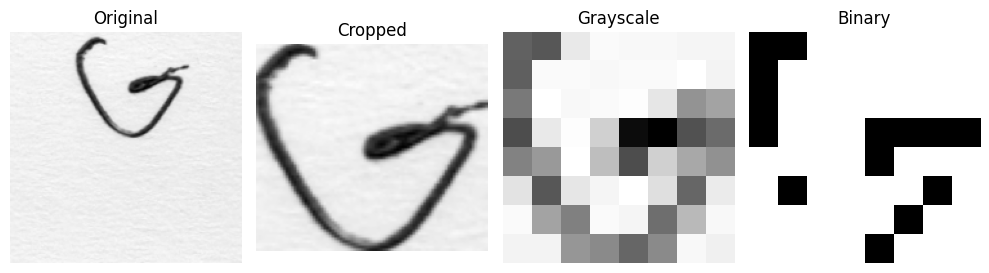

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# --------- Pick a random image from dataframe ---------
# df_info should contain columns 'filename' and 'digit'
random_row = df_info.sample(n=1).iloc[0]  # randomly select one row
img_name = random_row['filename']         # get image filename
label = random_row['digit']               # get corresponding label

# Build full path to the image
img_path = os.path.join(image_folder, img_name)

# --------- Load original image ---------
img_original = Image.open(img_path).convert('L')  # convert to grayscale
img_array = np.array(img_original)               # convert to numpy array for processing

# --------- Crop whitespace using threshold ---------
# Define threshold for what counts as "background"
threshold = 128  # pixel values >= threshold are considered background

# Create a boolean mask where pixels < threshold are foreground
mask = img_array < threshold

if mask.any():
    # Find coordinates of foreground pixels
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)   # top-left corner
    y1, x1 = coords.max(axis=0)+1 # bottom-right corner (+1 because slice end is exclusive)
    # Crop image to bounding box
    img_cropped = img_original.crop((x0, y0, x1, y1))
else:
    # If no foreground detected, just copy original
    img_cropped = img_original.copy()

# --------- Resize cropped image ---------
# Resize image to 8x8 pixels (e.g., for ML feature input)
img_resized = img_cropped.resize((8,8))

# --------- Convert to array ---------
img_array_resized = np.array(img_resized, dtype=np.float32)

# --------- Normalize grayscale to [0,1] ---------
img_gray = (img_array_resized - img_array_resized.min()) / (img_array_resized.max() - img_array_resized.min())

# --------- Convert to binary image using threshold ---------
img_binary = (img_gray >= 0.5).astype(np.float32)  # pixels >=0.5 become 1, else 0

# --------- Visualize all stages ---------
plt.figure(figsize=(10,5))

plt.subplot(1,4,1)
plt.imshow(img_original, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_cropped, cmap="gray")
plt.title("Cropped")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(img_gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(img_binary, cmap="gray")
plt.title("Binary")
plt.axis("off")

plt.tight_layout()
plt.show()


# Flattening & preprocessing grayscale and binary images for ML

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch

# ---------------- Paths ----------------
image_folder = "./../data/training-a"
output_folder = "./../features/training-a/flattened_arrays"
csv_file = "./../data/training-a.csv"  # replace with your CSV path

os.makedirs(output_folder, exist_ok=True)

# ---------------- Load labels CSV ----------------
df = pd.read_csv(csv_file)
filename_to_label = dict(zip(df['filename'], df['digit']))

# ---------------- Helper Function ----------------
def flatten_image(img_path, binary=False, resize_to=(8,8), threshold_crop=128):
    """
    Loads an image, crops whitespace, resizes, normalizes,
    converts to binary (optional), and flattens to a 1D array.
    """
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)

    # Crop whitespace/background
    mask = img_array < threshold_crop  # non-background pixels
    if mask.any():
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        img = img.crop((x0, y0, x1, y1))

    # Resize
    img = img.resize(resize_to)

    # Normalize
    img_array = np.array(img, dtype=np.float32)
    img_norm = (img_array - img_array.min()) / (img_array.max() - img_array.min())

    # Convert to binary if requested
    if binary:
        img_norm = (img_norm >= 0.5).astype(np.float32)

    return img_norm.flatten()

# ---------------- Process Images ----------------
files = sorted(os.listdir(image_folder))
X_gray, y_gray = [], []
X_binary, y_binary = [], []

for f in tqdm(files, desc="Processing images"):
    if f not in filename_to_label:
        continue  # skip any file not in CSV
    label = int(filename_to_label[f])
    path = os.path.join(image_folder, f)

    # Grayscale
    X_gray.append(flatten_image(path, binary=False))
    y_gray.append(label)

    # Binary
    X_binary.append(flatten_image(path, binary=True))
    y_binary.append(label)

# Convert to numpy arrays
X_gray = np.array(X_gray, dtype=np.float32)
y_gray = np.array(y_gray, dtype=np.int64)
X_binary = np.array(X_binary, dtype=np.float32)
y_binary = np.array(y_binary, dtype=np.int64)

# Save arrays
np.save(os.path.join(output_folder, "X_gray.npy"), X_gray)
np.save(os.path.join(output_folder, "y_gray.npy"), y_gray)
np.save(os.path.join(output_folder, "X_binary.npy"), X_binary)
np.save(os.path.join(output_folder, "y_binary.npy"), y_binary)

print("✅ Flattening and cropping complete!")
print(f"Grayscale shape: {X_gray.shape}, Binary shape: {X_binary.shape}")

Processing images: 100%|████████████████████████████████████████████████████████| 19702/19702 [02:54<00:00, 113.21it/s]

✅ Flattening and cropping complete!
Grayscale shape: (19702, 64), Binary shape: (19702, 64)
